In [30]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from math import sqrt, pi
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
np.random.seed(42)

In [32]:
# Konfigurasi Rule Based
RB_CONFIG = {
    'lambda_val': 5,
    'prior': 50,
    'win_es': 5,        # Window size kestabilan
    'delta_thr': 2.0,   # Threshold kestabilan
    'min_items': 20,    # Minimum soal
    'max_items': 40,    # Maksimal soal
    'w_cog': {'C1': 1.0, 'C2': 1.1, 'C3': 1.2, 'C4': 1.3, 'C5': 1.4, 'C6': 1.5},
    'w_diff': {'D1': 1.0, 'D2': 1.2, 'D3': 1.4}
}

In [33]:
# Konfigurasi CAT
CAT_CONFIG = {
    'se_target': 0.32,
    'min_items': 20,
    'max_items': 40,
    'estimator': 'EAP'
}

In [34]:
def generate_bank():
    items = []
    id_counter = 1
    # 56 soal per sel = 1008 total
    for c_idx, c in enumerate(['C1', 'C2', 'C3', 'C4', 'C5', 'C6']):
        for d_idx, d in enumerate(['D1', 'D2', 'D3']):
            for _ in range(56):
                b = -2.0 + (c_idx * 0.6) + (d_idx * 0.3) + np.random.normal(0, 0.1)
                a = np.random.uniform(0.8, 1.5)
                items.append({
                    'id': id_counter, 'C': c, 'D': d, 'a': a, 'b': b,
                    'w_cog': RB_CONFIG['w_cog'][c],
                    'w_diff': RB_CONFIG['w_diff'][d]
                })
                id_counter += 1
    return pd.DataFrame(items)

BANK_DF = generate_bank()

In [35]:
def p_correct(theta, a, b):
    z = a * (theta - b)
    return 1.0 / (1.0 + np.exp(-z))

In [36]:
def item_information(theta, a, b):
    p = p_correct(theta, a, b)
    return (a**2) * p * (1.0 - p)

In [37]:
def theta_eap_grid(responses, a_vec, b_vec, grid=np.linspace(-4, 4, 161)):
    prior = np.exp(-0.5 * (grid ** 2)) / sqrt(2.0 * pi) # asumsi N(0,1)
    like = np.ones_like(grid, dtype=float)
    for r, a, b in zip(responses, a_vec, b_vec):
        p = 1.0 / (1.0 + np.exp(-a * (grid - b)))
        like *= (p ** r) * ((1.0 - p) ** (1 - r)) + 1e-300
    post = prior * like
    post /= np.trapz(post, grid) + 1e-300 # normalisasi

    th_eap = float(np.trapz(grid * post, grid)) # skor Theta
    var = float(np.trapz(((grid - th_eap) ** 2) * post, grid))
    se = np.sqrt(max(var, 1e-12))

    return th_eap, se

In [38]:
def select_by_max_info(theta_est, available_df):
    # Hitung info item untuk theta saat ini
    infos = item_information(theta_est, available_df['a'].values, available_df['b'].values)
    max_info = np.max(infos)
    # Ambil kandidat dengan info tertinggi
    cand = available_df.iloc[np.where(np.isclose(infos, max_info))[0]]
    # Jika ada beberapa, pilih random salah satu
    row = cand.sample(1).iloc[0]
    return row

In [39]:
def run_cat_simulation(theta_true):
    theta_est = 0.0
    used_ids = set()
    history = []

    resp_list, a_list, b_list = [], [], []

    for i in range(CAT_CONFIG['max_items']):
        # 1. Pilih Soal (Max Info)
        avail = BANK_DF[~BANK_DF['id'].isin(used_ids)]
        if avail.empty: break

        item = select_by_max_info(theta_est, avail)
        used_ids.add(item['id'])

        # 2. Jawab
        p = p_correct(theta_true, item['a'], item['b'])
        is_correct = 1 if np.random.random() < p else 0

        # 3. Record & Estimasi Ulang
        resp_list.append(is_correct)
        a_list.append(item['a'])
        b_list.append(item['b'])

        theta_est, se = theta_eap_grid(np.array(resp_list), np.array(a_list), np.array(b_list))

        history.append({
            'q_no': i+1, 'C': item['C'], 'D': item['D'],
            'is_correct': is_correct, 'b': item['b'],
            'theta_est': theta_est, 'se': se
        })

        # 4. Stop Condition (Standard Error Target)
        # Stop jika sudah minimal item DAN SE sudah kecil (presisi tinggi)
        if len(history) >= CAT_CONFIG['min_items'] and se <= CAT_CONFIG['se_target']:
            break

    # Konversi Theta Akhir ke Skala 0-100 (Domain Score Method)
    # Menghitung rata-rata probabilitas benar siswa pada SELURUH bank soal
    score_0_100 = p_correct(theta_est, BANK_DF['a'].values, BANK_DF['b'].values).mean() * 100.0

    return score_0_100, history

In [40]:
def get_next_routing(c, d, is_correct, mode='slowing'):
    c_levels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    d_levels = ['D1', 'D2', 'D3']
    c_idx = c_levels.index(c)
    d_idx = d_levels.index(d)

    if is_correct:
        if mode == 'jumping':
            if d == 'D3':
                if c_idx < 5: return c_levels[c_idx+1], 'D3'
                else: return 'C6', 'D3'
            else: return c, d_levels[d_idx+1]
        else: # slowing
            if d == 'D3':
                if c_idx < 5: return c_levels[c_idx+1], 'D1'
                else: return 'C6', 'D3'
            else: return c, d_levels[d_idx+1]
    else:
        if d == 'D1': return c, 'D1'
        else: return c, d_levels[d_idx-1]

In [41]:
def run_rb_simulation(theta, mode='slowing'):
    history = []
    curr_c, curr_d = 'C1', 'D1'
    total_w_attempted = 0
    total_w_correct = 0
    es_history = []
    answered_ids = []

    # perlu flag untuk menandai sudah pernah stabil

    for i in range(RB_CONFIG['max_items']):
        pool = BANK_DF[(BANK_DF['C'] == curr_c) & (BANK_DF['D'] == curr_d) & (~BANK_DF['id'].isin(answered_ids))]
        if pool.empty: pool = BANK_DF[~BANK_DF['id'].isin(answered_ids)]
        if pool.empty: break

        item = pool.sample(1).iloc[0]
        answered_ids.append(item['id'])

        p_val = p_correct(theta, item['a'], item['b'])
        is_correct = 1 if np.random.random() < p_val else 0

        weight = item['w_cog'] * item['w_diff']
        total_w_attempted += weight
        if is_correct: total_w_correct += weight

        es_val = ((RB_CONFIG['lambda_val'] * RB_CONFIG['prior']) + (100 * total_w_correct)) / \
                 (RB_CONFIG['lambda_val'] + total_w_attempted)
        es_history.append(es_val)

        history.append({
            'q_no': i+1, 'C': curr_c, 'D': curr_d,
            'is_correct': is_correct, 'es': es_val, 'b': item['b']
        })

        should_stop = False
        n = len(es_history)
        if n >= RB_CONFIG['win_es']:
            if (max(es_history[-RB_CONFIG['win_es']:]) - min(es_history[-RB_CONFIG['win_es']:])) <= RB_CONFIG['delta_thr']:
                should_stop = True

        if n < RB_CONFIG['min_items']: should_stop = False

        if should_stop: break

        curr_c, curr_d = get_next_routing(curr_c, curr_d, is_correct, mode)

    final_score = (total_w_correct / total_w_attempted * 100) if total_w_attempted > 0 else 0
    return final_score, history


In [42]:
N_STUDENTS = 10000
thetas = np.random.normal(0, 1, N_STUDENTS)
results = []

for idx, th in enumerate(thetas):
    true_score_perc = p_correct(th, BANK_DF['a'], BANK_DF['b']).mean() * 100

    # 1. CAT
    cat_score, cat_hist = run_cat_simulation(th)
    results.append({'student_id': idx, 'method': 'CAT', 'theta': th, 'true_score': true_score_perc, 'score': cat_score, 'items': len(cat_hist), 'history': cat_hist})

    # 2. Slowing Rule
    slow_score, slow_hist = run_rb_simulation(th, 'slowing') #C1-D1-2-3 -> C2-D1-2-3 -> C3-D1-2-3
    results.append({
        'student_id': idx, 'method': 'Slowing Rule', 'theta': th, 'true_score': true_score_perc,
        'score': slow_score, 'items': len(slow_hist), 'history': slow_hist
    })

    # 3. Jumping Rule
    jump_score, jump_hist = run_rb_simulation(th, 'jumping') #C1-D1-2-3 -> C2-D3 -> C3-D3
    results.append({
        'student_id': idx, 'method': 'Jumping Rule', 'theta': th, 'true_score': true_score_perc,
        'score': jump_score, 'items': len(jump_hist), 'history': jump_hist
    })

df_res = pd.DataFrame(results)

In [43]:
df_students = df_res[['student_id', 'theta']].drop_duplicates()
labels_5 = ['Sangat Rendah', 'Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']
df_students['group_5'] = pd.qcut(df_students['theta'], 5, labels=labels_5)

In [44]:
if 'quartile' in df_res.columns:
    df_res = df_res.drop(columns=['quartile'])

In [45]:
df_res_5 = df_res.merge(df_students[['student_id', 'group_5']], on='student_id')

In [46]:
summary_rows = []
methods = ['CAT', 'Slowing Rule', 'Jumping Rule']

In [47]:
for method in methods:
    # Filter data berdasarkan metode
    subset = df_res[df_res['method'] == method]

    # 1. Korelasi (Pearson r)
    r_val, _ = pearsonr(subset['score'], subset['true_score'])

    # 2. Error Metrics
    error = subset['score'] - subset['true_score']
    rmse = np.sqrt((error**2).mean())
    bias = error.mean()

    # 3. Item Metrics (Jumlah Soal)
    items_mean = subset['items'].mean()
    items_min = subset['items'].min()
    items_max = subset['items'].max()

    # 4. Score Metrics (Nilai Akhir)
    score_mean = subset['score'].mean()
    score_min = subset['score'].min()
    score_max = subset['score'].max()


    summary_rows.append({
        'Metode': method,
        'R': r_val,
        'RMSE': rmse,
        'Bias': bias,
        'Soal_Rata2': items_mean,
        'Soal_Min': items_min,
        'Soal_Max': items_max,
        'Nilai_Rata2': score_mean,
        'Nilai_Min': score_min,
        'Nilai_Max': score_max,
    })

# Buat DataFrame Summary
df_summary = pd.DataFrame(summary_rows)

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(df_summary)

         Metode     R   RMSE   Bias  Soal_Rata2  Soal_Min  Soal_Max  Nilai_Rata2  Nilai_Min  Nilai_Max
0           CAT 0.953  5.709  0.117      20.311        20        40       53.484      4.456     96.723
1  Slowing Rule 0.868 11.068  0.135      38.588        20        40       53.503      0.000    100.000
2  Jumping Rule 0.749 15.749 -8.786      36.894        20        40       44.581      0.000    100.000


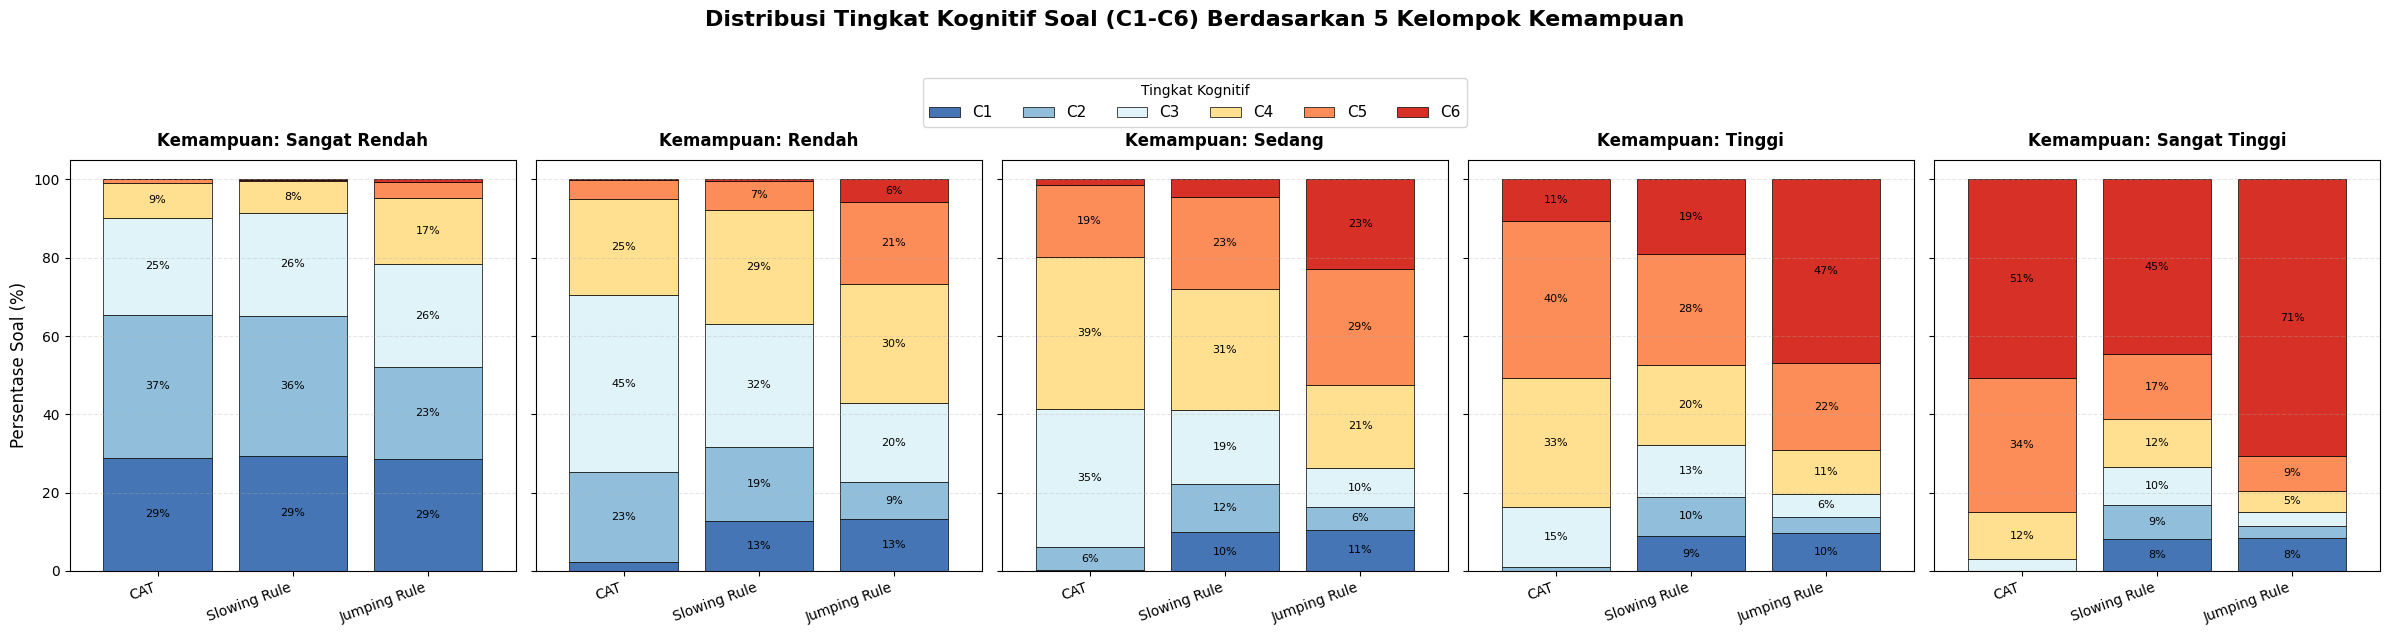

In [55]:
cog_items_5 = []
for _, row in df_res_5.iterrows():
    # Loop melalui setiap soal yang dikerjakan (history)
    for h in row['history']:
        cog_items_5.append({
            'Method': row['method'],
            'Group': row['group_5'],
            'C': h['C']
        })
df_cog_5 = pd.DataFrame(cog_items_5)

df_items_avg = df_res_5.groupby(
    ['method', 'group_5'], 
    observed=True
)['items'].mean().reset_index()

methods = ['CAT', 'Slowing Rule', 'Jumping Rule']
c_levels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

colors_cog = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

fig, axes = plt.subplots(1, 5, figsize=(24, 6), sharey=True)
fig.suptitle('Distribusi Tingkat Kognitif Soal (C1-C6) Berdasarkan 5 Kelompok Kemampuan',
             fontsize=16, fontweight='bold', y=1.05)

for i, group in enumerate(labels_5):
    ax = axes[i]

    # Filter data per kelompok
    subset = df_cog_5[df_cog_5['Group'] == group]

    # Hitung persentase
    if not subset.empty:
        cross = pd.crosstab(subset['Method'], subset['C'], normalize='index') * 100
        # Reindex untuk memastikan urutan C1-C6 dan Metode konsisten
        cross = cross.reindex(index=methods, columns=c_levels).fillna(0)

        # Plot Stacked Bar
        cross.plot(kind='bar', stacked=True, ax=ax, color=colors_cog,
                   width=0.8, edgecolor='black', linewidth=0.5)

    ax.set_title(f"Kemampuan: {group}", fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel("")
    ax.set_xticklabels(methods, rotation=20, ha='right', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.get_legend().remove()

    # Label Persentase
    for c in ax.containers:
        # Hanya tampilkan label jika barnya cukup besar (>5%)
        labels = [f'{v.get_height():.0f}%' if v.get_height() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=8)

    if i == 0:
        ax.set_ylabel("Persentase Soal (%)", fontsize=12)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),
           ncol=6, fontsize=11, title="Tingkat Kognitif")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

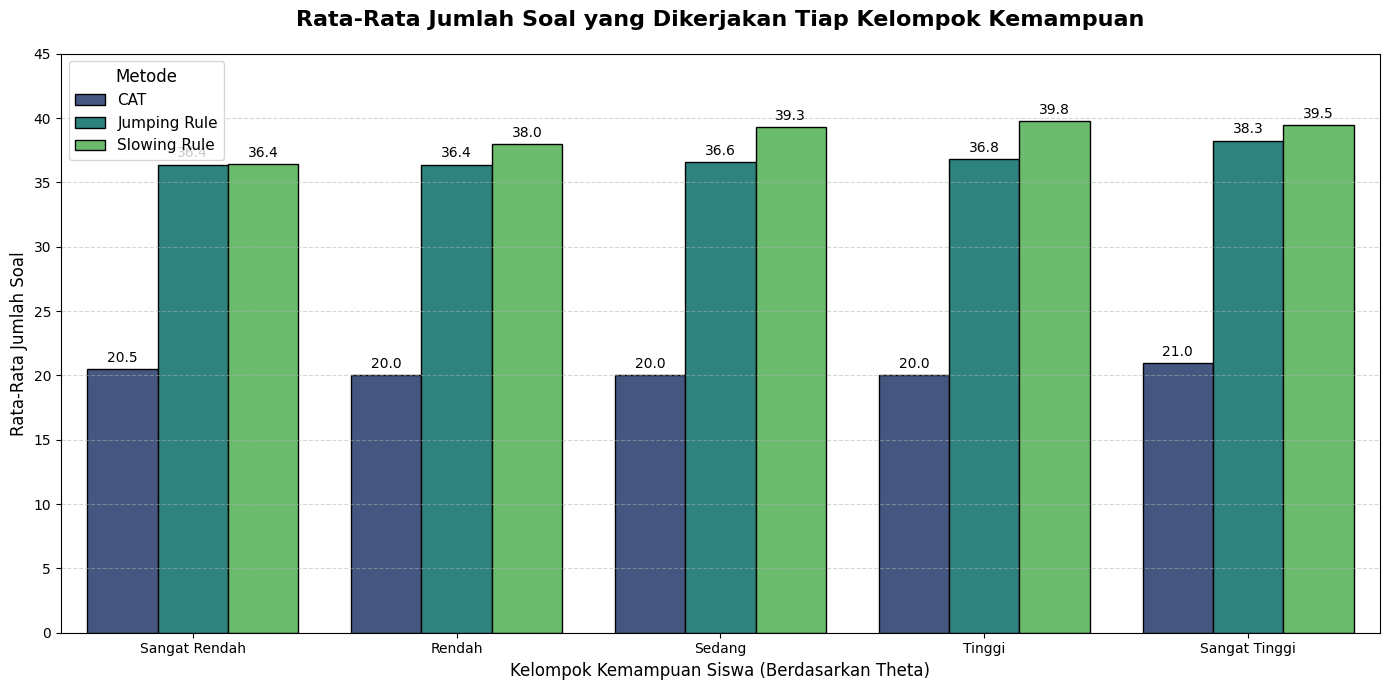

In [51]:
plt.figure(figsize=(14, 7))

# Menggunakan Seaborn barplot untuk kemudahan grouping
sns.barplot(data=df_items_avg, x='group_5', y='items', hue='method',
            palette='viridis', edgecolor='black')

plt.title('Rata-Rata Jumlah Soal yang Dikerjakan Tiap Kelompok Kemampuan',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Kelompok Kemampuan Siswa (Berdasarkan Theta)', fontsize=12)
plt.ylabel('Rata-Rata Jumlah Soal', fontsize=12)
plt.ylim(0, 45) # Set limit y sedikit di atas max soal (40)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Metode', fontsize=11, title_fontsize=12)

# Menambahkan label nilai di atas batang
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

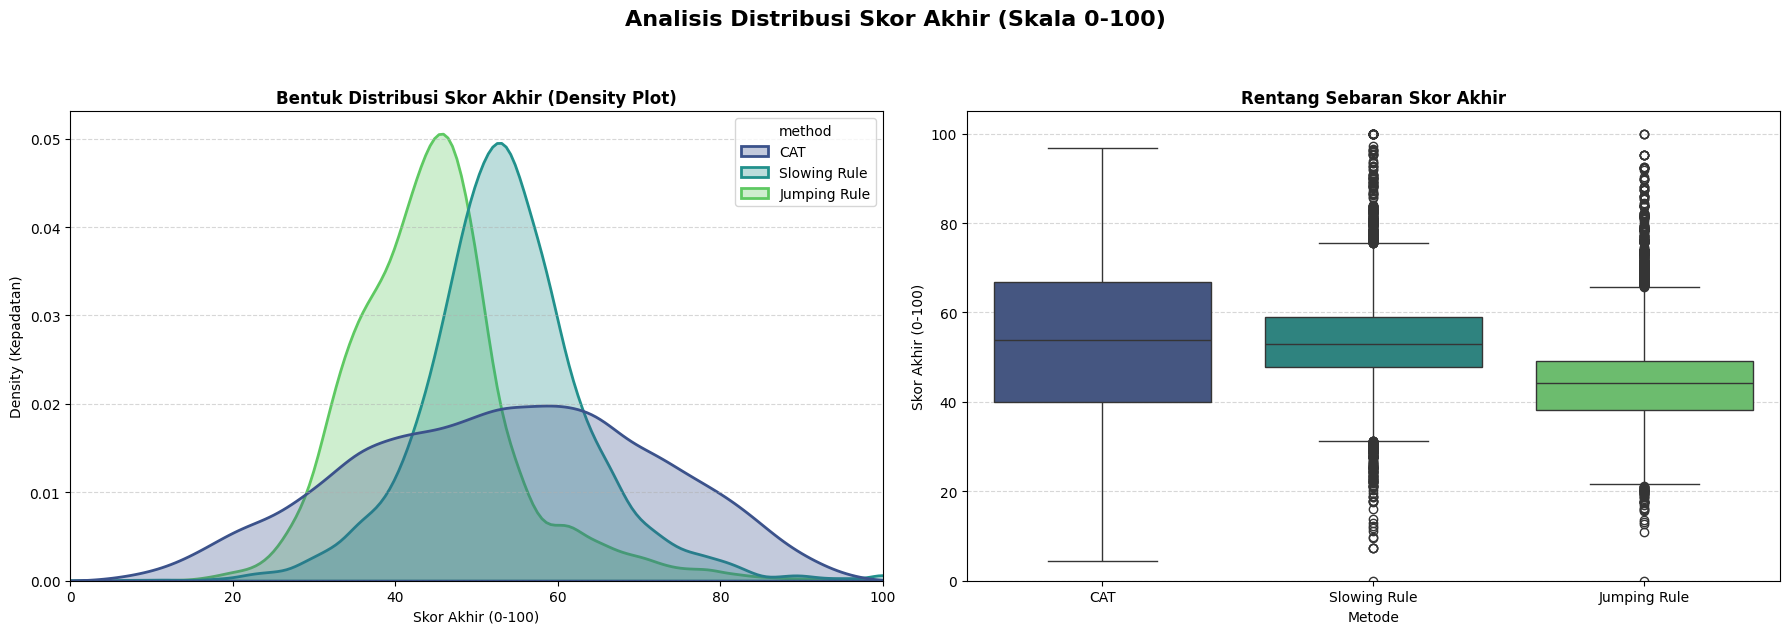

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Analisis Distribusi Skor Akhir (Skala 0-100)', fontsize=16, fontweight='bold', y=1.05)

# Menunjukkan kepadatan/frekuensi skor di setiap titik
sns.kdeplot(data=df_res, x='score', hue='method', fill=True,
            common_norm=False, palette='viridis', alpha=0.3, linewidth=2, ax=axes[0])

axes[0].set_title('Bentuk Distribusi Skor Akhir (Density Plot)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Skor Akhir (0-100)')
axes[0].set_ylabel('Density (Kepadatan)')
axes[0].set_xlim(0, 100)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)


# Menunjukkan Median, Quartile, dan Outlier
sns.boxplot(data=df_res, x='method', y='score', hue='method',
            palette='viridis', dodge=False, ax=axes[1])

axes[1].set_title('Rentang Sebaran Skor Akhir', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Metode')
axes[1].set_ylabel('Skor Akhir (0-100)')
axes[1].set_ylim(0, 105)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()